In [7]:
print('..running')
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim.lr_scheduler as lr_scheduler
#from pytorch_model_summary import summary
import yaml
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from util import samples_generated, samples_real, plot_curve
import idf
from train import evaluation, training 
from data import load_data
from neural_networks import nnetts

..running


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

result_dir = 'results/validate'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'idf-4'

In [31]:
D = 64   # input dimension
M = D * 4  # the number of neurons in scale (s) and translation (t) nets
lr = 5e-3 # learning rate
num_epochs = 1000
max_patience = 20 # Early Stopping
num_flows = 4 # The number of invertible transformations
lam = 0. # Regularization Hyperparameter
n_mixtures = 5 # Number of latent mixing variables
batch_size = 64

hyperparameters = {'D': D, 
                   'M': M,
                   'lr': lr,
                   'num_epochs': num_epochs,
                   'max_patience': max_patience,
                   'num_flows': num_flows,
                   'batch_size': batch_size,
                   'lambda': lam,
                   'n_mixtures': n_mixtures
                    }
with open(result_dir + '/hyperparameters.yaml', 'w') as file:
    yaml.dump(hyperparameters, file)

In [32]:
train_data, val_data, test_data = load_data('sklearn')
# Create data loaders
training_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [33]:
netts = nnetts(D, M)
model = idf.IDF4(netts, num_flows, n_mixtures = n_mixtures, D=D).to(device)
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)
# Training procedure
nll_val = training(name=name, result_dir = result_dir, max_patience=max_patience, num_epochs=num_epochs, model=model, optimizer=optimizer,
                   scheduler=scheduler, training_loader=training_loader, val_loader=val_loader, device=device, lam=lam)

with open(result_dir + '/val_loss.txt', "w") as file:
    for item in nll_val:
        file.write(f"{item}\n")

test_loss = evaluation(name=result_dir + '/' + name, test_loader=test_loader)
f = open(result_dir + '/test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_generated(result_dir + '/' + name, test_loader, 8)
plot_curve(result_dir + '/' + name, nll_val)

Epoch: 0, train nll=173.06971740722656, val nll=176.473291015625
saved!
Epoch: 1, train nll=168.22286987304688, val nll=171.33269252232142
saved!
Epoch: 2, train nll=163.78543090820312, val nll=167.45395926339285
saved!
Epoch: 3, train nll=159.32516479492188, val nll=163.9019224330357
saved!
Epoch: 4, train nll=156.17506408691406, val nll=160.56386160714285
saved!
Epoch: 5, train nll=152.81822204589844, val nll=158.14012137276785
saved!
Epoch: 6, train nll=149.7782440185547, val nll=155.40924386160714
saved!
Epoch: 7, train nll=146.67788696289062, val nll=153.71955915178572
saved!
Epoch: 8, train nll=143.2123260498047, val nll=151.51263113839286
saved!
Epoch: 9, train nll=141.6419677734375, val nll=149.48371512276785
saved!
Epoch: 10, train nll=139.0266876220703, val nll=147.91493722098215
saved!
Epoch: 11, train nll=136.7530975341797, val nll=146.467919921875
saved!
Epoch: 12, train nll=135.53392028808594, val nll=145.41988002232142
saved!
Epoch: 13, train nll=133.13052368164062, val 

RuntimeError: shape '[16, 1, 64]' is invalid for input of size 64

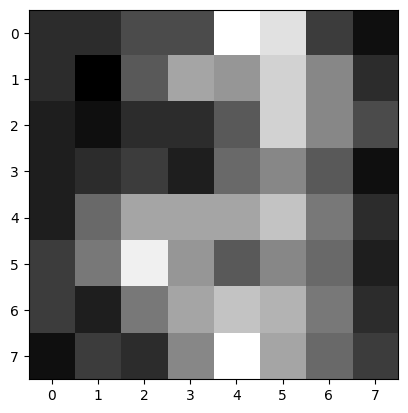

In [36]:
import matplotlib.pyplot as plt
import numpy as np
for i in range(10):
    x = next(iter(test_loader)).detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(result_dir + '/' + name + '.model')
    model_best.eval()
    x = model_best.sample(1).detach().numpy()
    plottable_image = np.reshape(x, (8, 8))
    plt.imshow(plottable_image, cmap='gray')
